Test for unitary matrices which respresent conservative physics.

In [1]:
import numpy as np
import numpy.linalg as LA
import scipy.integrate as scii
from piDMD.pendulum import *
from piDMD.piDMD import *

Generate data

In [2]:
# define parameters of problem
# lengths of rods
l1 = 1
l2 = 1.5
# masses and gravity
m1 = 1
m2 = 1.5
g = 9.81
# concatenate parameters
params = [l1, l2, m1, m2, g]

# construct linearised energy inner product
W = np.zeros((4, 4))
W[0, 0] = (m1/2 + m2/2) * g * l1
W[1, 1] = m2/2 * g * l2
W[2, 2] = (m1/2 + m2/2) * l1 * l1
W[3, 2] = m2/2 * l1 * l2
W[2, 3] = m2/2 * l1 * l2
W[3, 3] = m2/2 * l2 * l2
# calculate inner product
C = LA.cholesky(W)
# to be consistent with matlab
C = C.conj().T

# set number of samples and span
tend = 30
nt = 1000
tspan = np.linspace(0, tend, nt)

# set initial conditions
theta1 = 0.4
theta1_prime = 0
theta2 = 0.7
theta2_prime = 0
y0 = [theta1, theta1_prime, theta2, theta2_prime]

# solve ODE
sol = scii.solve_ivp(pendulum, (0, tend), y0, t_eval=tspan, args=(params,))

# extract data
th1 = sol["y"][0]
th2 = sol["y"][2]
th1dt = sol["y"][1]
th2dt = sol["y"][3]
x = np.zeros(sol["y"].shape)
x[0] = th1
x[1] = th2
x[2] = th1dt
x[3] = th2dt
# add noise
xn = x + 1e-1 * np.std(x, axis=1)[:, np.newaxis] * np.random.randn(*x.shape)

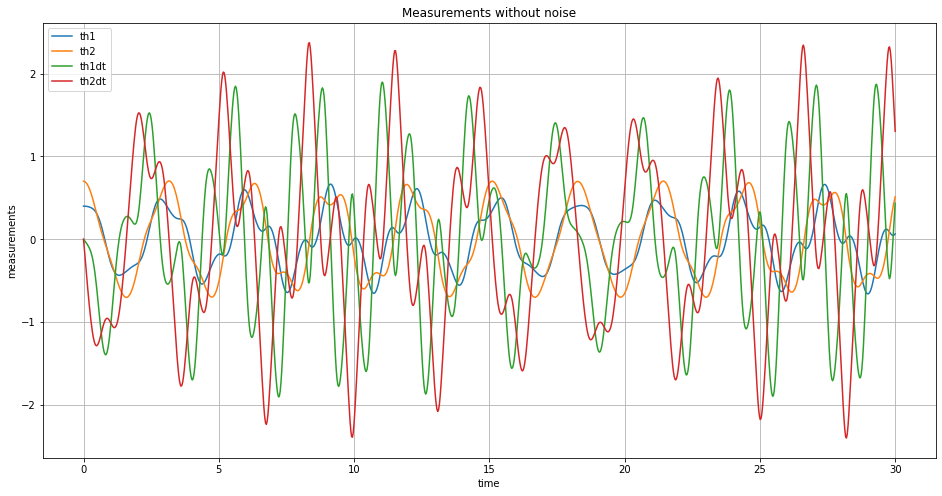

In [3]:
plot_data(sol["t"], x, "Measurements without noise")

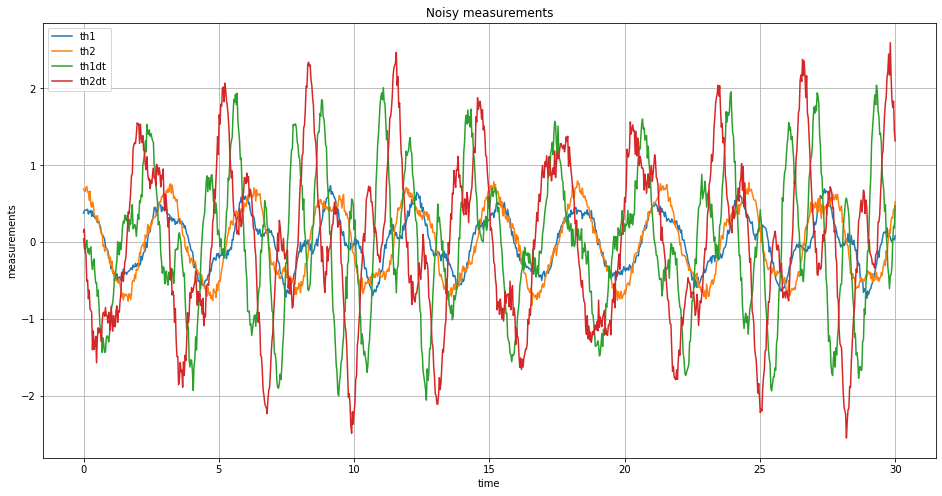

In [4]:
plot_data(sol["t"], xn, "Noisy measurements")

Since the energy of the system is the quantity which conserves we need to rescale data to energy norm before applying piDMD

In [5]:
# rescale measurements into energy norm
data_no_noise = C @ x
data = C @ xn

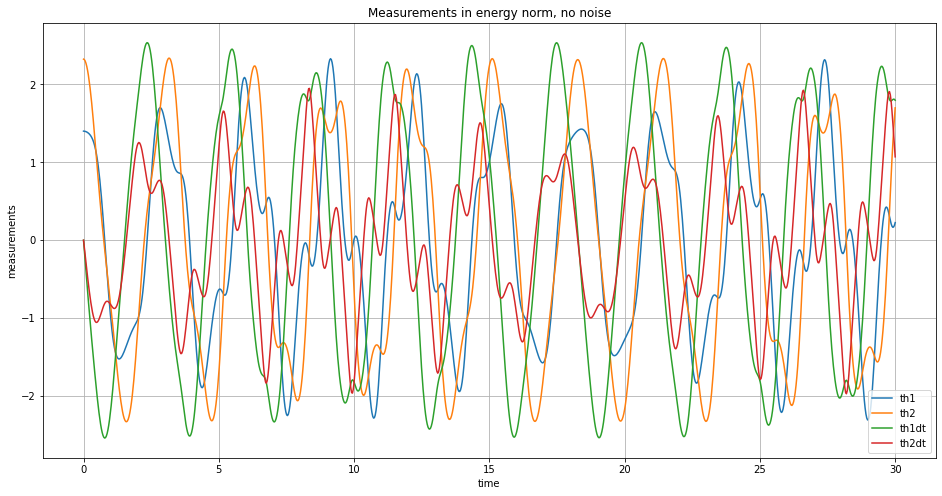

In [6]:
plot_data(sol["t"], data_no_noise, "Measurements in energy norm, no noise")

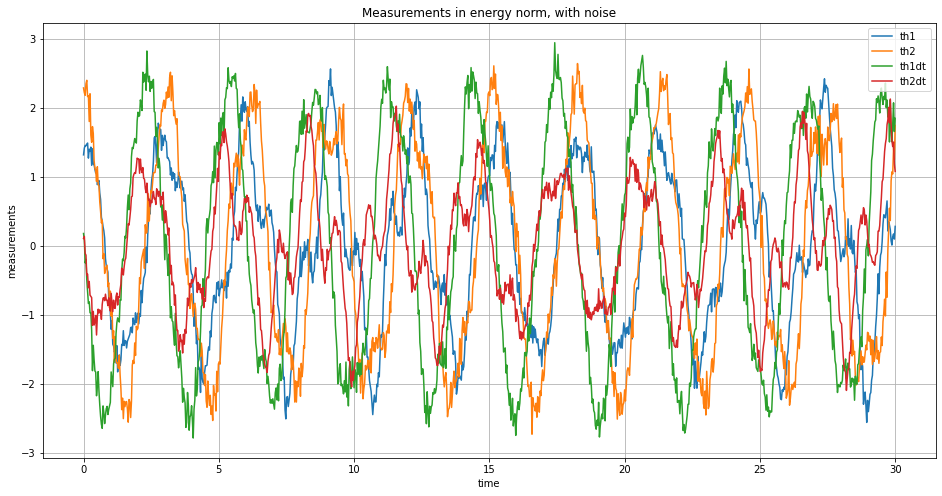

In [7]:
plot_data(sol["t"], data, "Measurements in energy norm, with noise")

Prepare X and Y using measurements in energy norm and apply unitary piDMD

In [8]:
X = data[:, 0:nt-1]
Y = data[:, 1:nt]

# train models
## energy preserving DMD
piA, piVals, piVecs = piDMD(X, Y, "orthogonal")
exA, exVals, exVecs = piDMD(X, Y, "exact")

# perform reconstructions
piRec = np.zeros((4, nt))
piRec[:, 0] = data[:, 0]
exRec = np.zeros((4, nt))
exRec[:, 0] = data[:, 0]

for i in range(1, nt):
    piRec[:, i] = piA(piRec[:, i-1])
    exRec[:, i] = exA(exRec[:, i-1])

Results

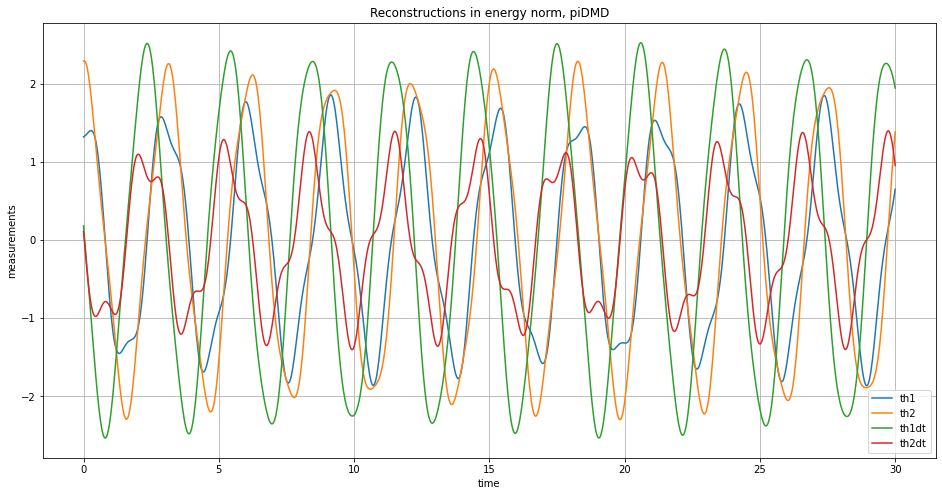

In [9]:
plot_data(sol["t"], piRec, "Reconstructions in energy norm, piDMD")

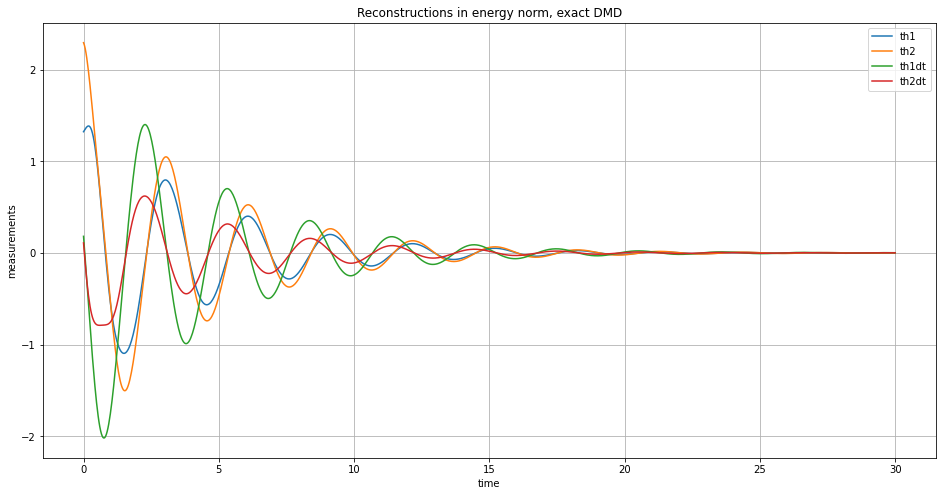

In [10]:
plot_data(sol["t"], exRec, "Reconstructions in energy norm, exact DMD")

In [11]:
# rescale reconstructions back into physical norm
fpiRec = LA.inv(C) @ piRec
fexRec = LA.inv(C) @ exRec

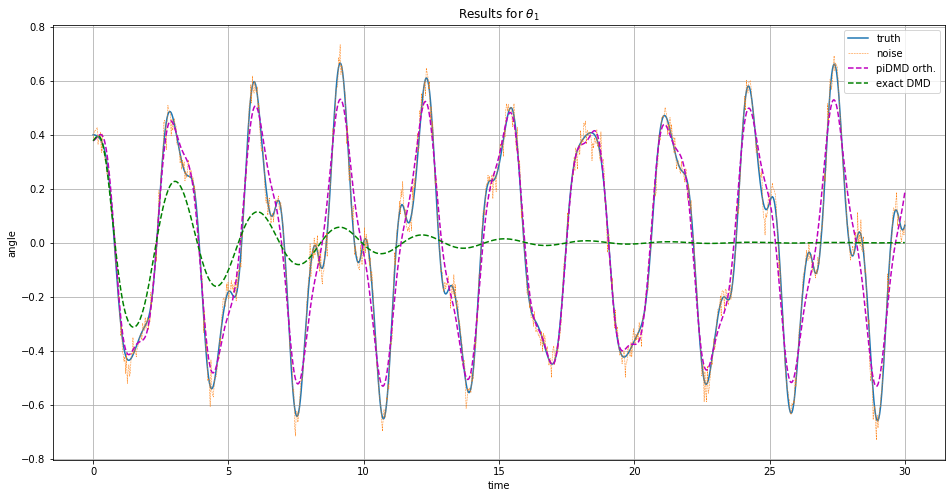

In [12]:
# plot results
idx = 0
plot_res(sol["t"], x[idx], xn[idx], fpiRec[idx], fexRec[idx], "$\\theta_1$", "angle")

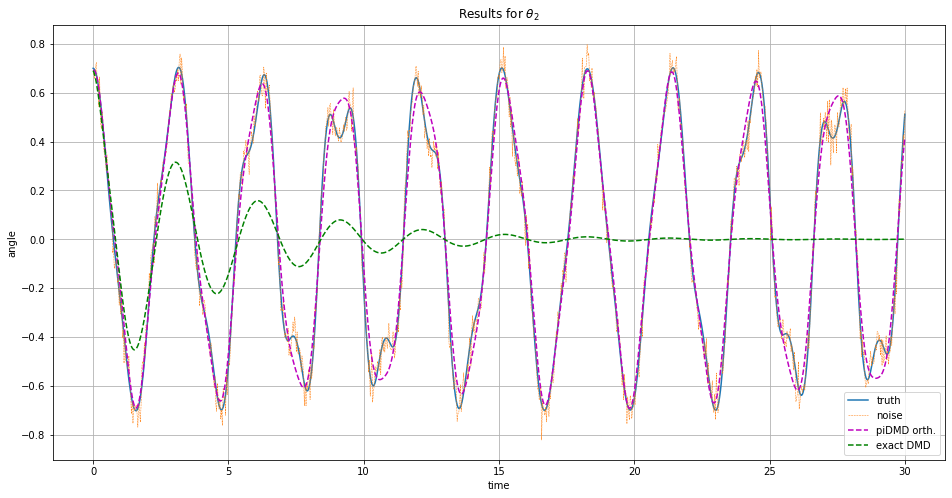

In [13]:
idx = 1
plot_res(sol["t"], x[idx], xn[idx], fpiRec[idx], fexRec[idx], "$\\theta_2$", "angle")

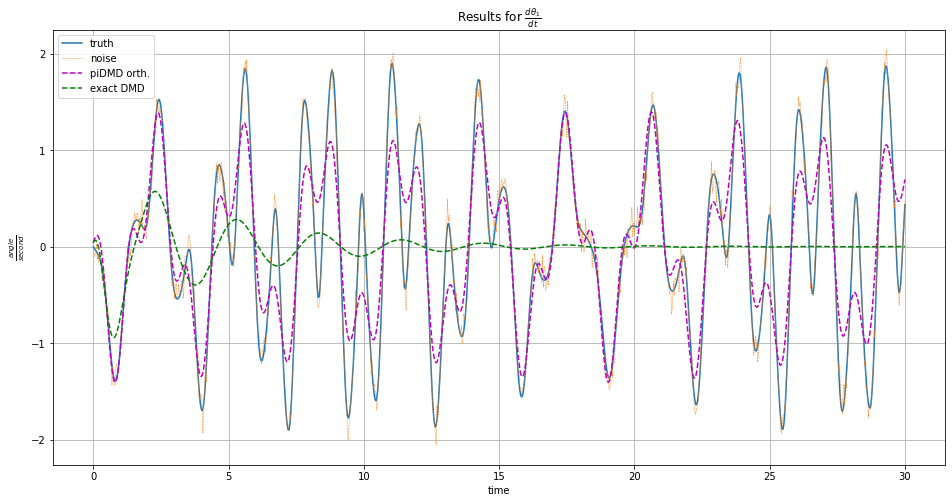

In [14]:
idx = 2
plot_res(sol["t"], x[idx], xn[idx], fpiRec[idx], fexRec[idx], "$\\frac{d \\theta_1}{dt}$", "$\\frac{angle}{second}$")

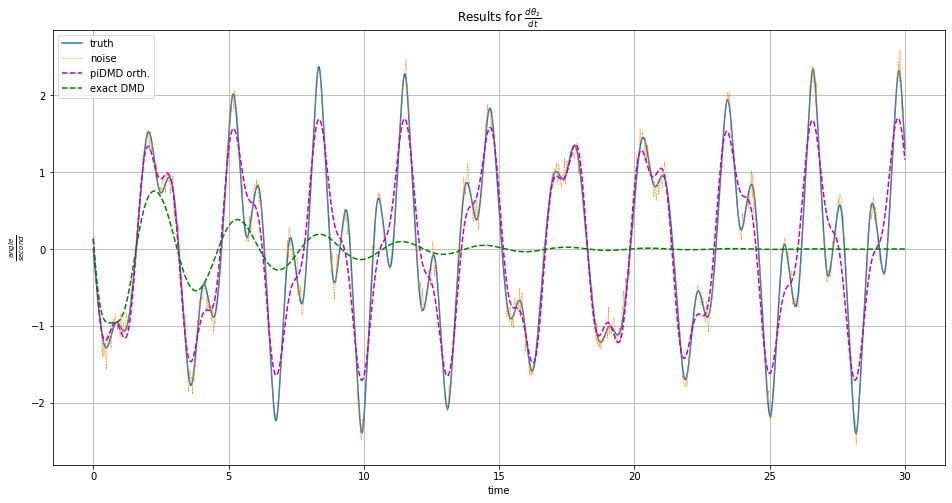

In [15]:
idx = 3
plot_res(sol["t"], x[idx], xn[idx], fpiRec[idx], fexRec[idx], "$\\frac{d \\theta_2}{dt}$", "$\\frac{angle}{second}$")

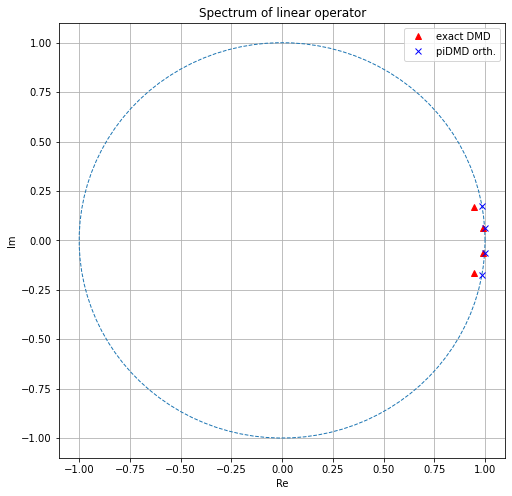

In [16]:
# eigendecomposition results
plt.figure(figsize=(8, 8))
circle_data = np.exp(1j * np.linspace(0, 2 * np.pi, 100))
plt.plot(circle_data.real, circle_data.imag, '--', linewidth=1)
plt.plot(exVals.real, exVals.imag, 'r^', label="exact DMD")
plt.plot(piVals.real, piVals.imag, 'bx', label="piDMD orth.")

plt.legend()
plt.title("Spectrum of linear operator")
plt.ylabel("Im")
plt.xlabel("Re")
plt.grid()
plt.show()

Matrix C is used for rescailing into energy norm. It is constructed from matrix W using Cholesky transformation

In [17]:
C

array([[3.50178526, 0.        , 0.        , 0.        ],
       [0.        , 3.32208519, 0.        , 0.        ],
       [0.        , 0.        , 1.11803399, 1.00623059],
       [0.        , 0.        , 0.        , 0.82158384]])

In [18]:
LA.inv(C)

array([[ 0.28556862,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.30101576,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.89442719, -1.09544512],
       [ 0.        ,  0.        ,  0.        ,  1.21716124]])

In [19]:
W

array([[12.2625 ,  0.     ,  0.     ,  0.     ],
       [ 0.     , 11.03625,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  1.25   ,  1.125  ],
       [ 0.     ,  0.     ,  1.125  ,  1.6875 ]])

In [20]:
C.T @ C

array([[12.2625 ,  0.     ,  0.     ,  0.     ],
       [ 0.     , 11.03625,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  1.25   ,  1.125  ],
       [ 0.     ,  0.     ,  1.125  ,  1.6875 ]])

In [21]:
C[3, 3]**2 + C[2, 3]**2

1.6875